In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn,optim
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import Dataset,DataLoader,random_split
from tqdm import tqdm
import torch.nn.functional as F
from tqdm.contrib.concurrent import process_map
from torchmetrics.classification import MulticlassAccuracy,MulticlassRecall
import lightning as L
from lightning.pytorch.callbacks import EarlyStopping,RichModelSummary

In [2]:
torch.set_float32_matmul_precision('high')
embedding_dim=4
max_article_length=300
batch_size=512

In [3]:
df=pd.read_csv('./text.csv',index_col='Unnamed: 0')
df.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


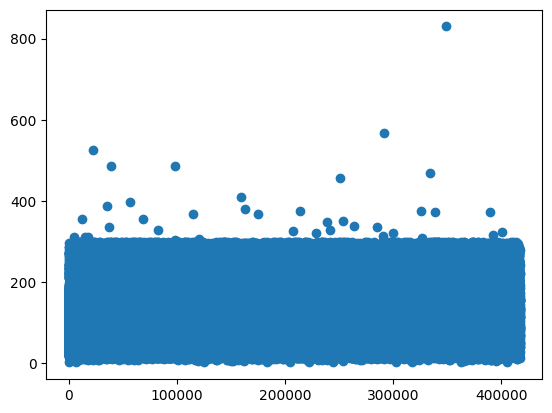

In [4]:
len_text=[]
for i in range(len(df)):
    len_text.append(len(df['text'][i]))
_=plt.scatter(np.arange(len(len_text)),len_text)

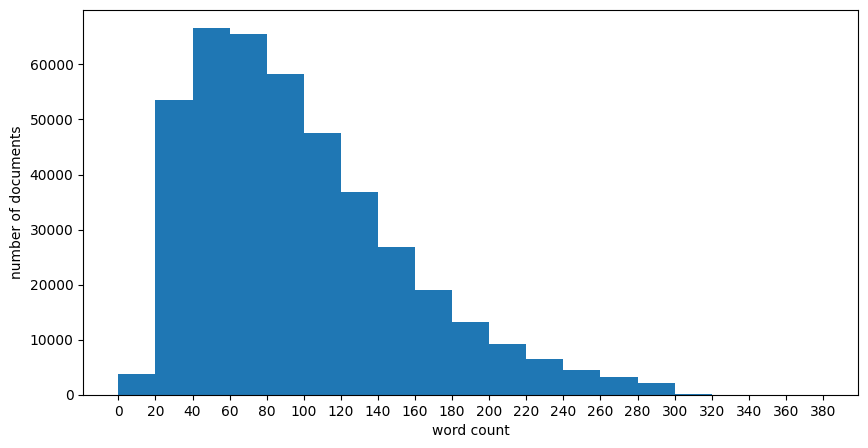

In [5]:
plt.figure(figsize=(10,5))
_=plt.hist(len_text,bins=np.arange(0,400,20))
plt.xticks(np.arange(0,400,20))
plt.xlabel('word count')
_=plt.ylabel('number of documents')

In [6]:
min(len_text),max(len_text),df.dtypes

(2,
 830,
 text     object
 label     int64
 dtype: object)

In [7]:
def remove_text_long_short(df,min_size,max_size):
    indices=[]
    for i in range(len(df)):
        if len(df['text'][i]) < min_size or len(df['text'][i]) > max_size:
            indices.append(i)
    df.drop(index=indices,inplace=True)
    df.reset_index(inplace=True,drop=True)
remove_text_long_short(df,20,300)

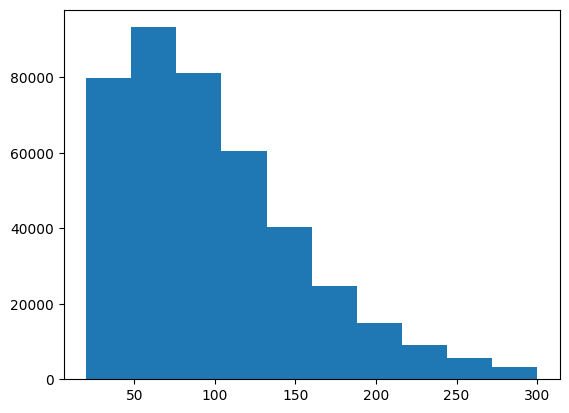

In [8]:
len_text=[]
for i in range(len(df)):
    len_text.append(len(df['text'][i]))
_=plt.hist(len_text)

In [9]:
print(df.isnull().values.any())
nlp=spacy.load('en_core_web_md',disable=['ner','parser'])
nlp.pipe_names

False


['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']

In [10]:
def pre_process_text(docs,length=df.shape[0]):
    pr_docs=[]
    with tqdm(range(length)) as pbar:
        for doc in docs:
            pr_docs.append(' '.join([
                token.text for token in doc[:max_article_length]
                  if not token.is_stop and not token.is_punct
                  ]))
            pbar.update(1)
    return pr_docs
docs=nlp.pipe(df['text'],batch_size=1500,n_process=-1)
t=pre_process_text(docs)
t[:3]

100%|██████████| 413008/413008 [04:12<00:00, 1636.31it/s]


['feel helpless heavy hearted',
 've enjoyed able slouch relax unwind frankly needed weeks end uni expo lately started find feeling bit listless good thing',
 'gave internship dmrg feeling distraught']

In [ ]:
df['pre_processed_text']=t
df.to_csv('processed_txt.csv')
df.isnull().values.any()
df=df.drop(index=47569).reset_index()

In [5]:
df=pd.read_csv('processed_txt.csv',index_col='index').drop('Unnamed: 0',axis=1)
vec=CountVectorizer()

index 47569 has words which do not correspond to anything in the vocab when passed through the vectorizer when using fit_transform on the whole dataset for some reason, remove it before processing.

In [6]:
class TextDataset(Dataset):
    def __init__(self,x,y,vectorizer,device='cuda'):
        super().__init__()
        self.x=x
        self.y=F.one_hot(torch.tensor(y,dtype=torch.long),6)
        self.X=[]
        self.device=device
        self.vectorizer=vectorizer
        self.setup()

    def padder(self,x):
        x=torch.tensor(x)
        return F.pad(x,pad=(300-x.shape[0],0))
    
    def transform(self,X,index):
            res=np.array(X.toarray()).nonzero()[1]
            return self.padder(res)
    def setup(self):
        X=self.vectorizer.fit_transform(self.x)
        res=process_map(self.transform,
                        X,
                        range(self.x.shape[0]),
                        tqdm_class=tqdm,
                        max_workers=16,
                        chunksize=1000,
                        total=self.x.shape[0],
                        desc='transforming data'
                        )
        self.X=[*res]
        self.X=torch.tensor(np.array(self.X),dtype=torch.int)
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, index):
        return self.X[index],self.y[index]
data=TextDataset(df['pre_processed_text'][:],df['label'][:],vec)
data.X.shape,data.y.shape

transforming data: 100%|██████████| 413007/413007 [02:34<00:00, 2681.63it/s]


(torch.Size([413007, 300]), torch.Size([413007, 6]))

In [7]:
class SentClassifier(nn.Module):
    def __init__(self,vocab=len(data.vectorizer.vocabulary_),emb_dim=embedding_dim,y_features=data.y.shape[1],features=data.X.shape[1],poolsize=2):
        super().__init__()
        self.emb=nn.Embedding(vocab,emb_dim)
        self.reshape=nn.Sequential(
            nn.Flatten(),
            nn.Unflatten(-1,(int(max_article_length/5),5*emb_dim))
        )
        self.avgpool=nn.AvgPool2d(poolsize)
        self.tf=nn.Transformer(5*emb_dim,2,4,4,4096,batch_first=True)
        self.flatten=nn.Sequential(nn.GELU(),nn.Flatten())
        self.output=nn.Sequential(
            nn.Linear(int(emb_dim*features/(poolsize**2)),y_features*4),
            nn.GELU(),
            nn.Linear(y_features*4,y_features),
            nn.GELU()
            )
    def forward(self,x):
        x=self.emb(x)
        x=self.reshape(x)
        x=self.tf(x,x)
        x=self.avgpool(x)
        x=self.flatten(x)
        x=self.output(x)
        return x
    
class LitSentClassifier(L.LightningModule):
    def __init__(self,loss,metrics,model=SentClassifier(),opt=optim.Adam, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model=model
        self.opt=opt
        self.loss=loss
        self.metrics=metrics
        self.example_input_array=torch.rand((6,300)).int()

    def configure_optimizers(self):
        return self.opt(self.model.parameters())
    
    def forward(self,x):
        return self.model(x)
    
    def predict_step(self,batch,batch_idx):
        x,_=batch
        return self.model(x)
    
    def log_loss_metrics(self,outputs,y):
        outputs,y=outputs.float(),y.float()
        loss=self.loss(outputs,y)
        dev_metrics=[]
        for i in self.metrics:
            dev_metrics.append(i.to(y))

        self.log(f'avg_{self.loss._get_name()}',loss.mean(),prog_bar=True,logger=True)
        for i in dev_metrics:
            self.log(f"avg_{i._get_name()}",(i(outputs,y)).mean(),logger=True,prog_bar=True)
        return loss

    def training_step(self,batch,batch_idx):
        x,y=batch
        outputs=self.model(x)
        return self.log_loss_metrics(outputs,y)
    
    def validation_step(self,batch,batch_idx):
        x,y=batch
        outputs=self.model(x)
        return self.log_loss_metrics(outputs,y)    

    def test_step(self,batch,batch_idx):
        x,y=batch
        outputs=self.model(x)
        return self.log_loss_metrics(outputs,y)
model=LitSentClassifier(loss=nn.CrossEntropyLoss(),metrics=[MulticlassAccuracy(6),MulticlassRecall(6)])
model=torch.compile(model)
sum([p.numel() for p in model.parameters() if p.requires_grad])

1671542

In [8]:
train,val,test=random_split(
    data,
    [0.8,0.1,0.1]
)
train_dl=DataLoader(train,batch_size,shuffle=True,num_workers=15)
test_dl=DataLoader(test,batch_size,shuffle=False,num_workers=15)
val_dl=DataLoader(val,batch_size,shuffle=False,num_workers=15)
model.eval()
with torch.no_grad():
    print(model(next(iter(test_dl))[0]).shape,next(iter(test_dl))[1].shape)
next(iter(val_dl))[0].shape,next(iter(val_dl))[1].shape

torch.Size([512, 6]) torch.Size([512, 6])


(torch.Size([512, 300]), torch.Size([512, 6]))

In [9]:
trainer=L.Trainer(
    max_epochs=50,
    min_epochs=10,
    callbacks=[EarlyStopping(monitor=f'avg_{model.loss._get_name()}'),RichModelSummary(2)],
    num_sanity_val_steps=1,
    enable_model_summary=True,
    profiler='simple',    
)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [10]:
trainer.fit(
    model,train_dataloaders=train_dl,val_dataloaders=val_dl
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


W0506 16:41:45.080000 16217 site-packages/torch/_dynamo/convert_frame.py:906] [2/8] torch._dynamo hit config.cache_size_limit (8)
W0506 16:41:45.080000 16217 site-packages/torch/_dynamo/convert_frame.py:906] [2/8]    function: 'hook_with_kwargs' (/opt/conda/lib/python3.11/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:101)
W0506 16:41:45.080000 16217 site-packages/torch/_dynamo/convert_frame.py:906] [2/8]    last reason: 2/0: ___check_type_id(L['_'], 110517461036192)                   
W0506 16:41:45.080000 16217 site-packages/torch/_dynamo/convert_frame.py:906] [2/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0506 16:41:45.080000 16217 site-packages/torch/_dynamo/convert_frame.py:906] [2/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃ Mode ┃                   In sizes ┃   Out sizes ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ 0 │ model         │ SentClassifier   │  1.7 M │ eval │                   [6, 300] │      [6, 6] │
│ 1 │ model.emb     │ Embedding        │  299 K │ eval │                   [6, 300] │ [6, 300, 4] │
│ 2 │ model.reshape │ Sequential       │      0 │ eval │                [6, 300, 4] │ [6, 60, 20] │
│ 3 │ model.avgpool │ AvgPool2d        │      0 │ eval │                [6, 60, 20] │ [6, 30, 10] │
│ 4 │ model.tf      │ Transformer      │  1.4 M │ eval │ [[6, 60, 20], [6, 60, 20]] │ [6, 60, 20] │
│ 5 │ model.flatten │ Sequential       │      0 │ eval │                [6, 30, 10] │    [6, 300] │
│ 6 │ model.output  │ Sequential       │  7.4 K │ eval │                   [6, 300] │      [6, 6] │
│ 7 │ loss          │ CrossEntropyLoss │      0 │ eval │                          ? │           ? │
└───┴───────────────┴──────────────────┴────────┴──────┴────────────────────────────┴─────────────┘

Trainable params: 1.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.7 M                                                                                                
Total estimated model params size (MB): 6                                                                          
Modules in train mode: 0                                                                                           
Modules in eval mode: 118

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

W0506 16:43:52.182000 16217 site-packages/torch/_dynamo/convert_frame.py:906] [15/8] torch._dynamo hit config.cache_size_limit (8)
W0506 16:43:52.182000 16217 site-packages/torch/_dynamo/convert_frame.py:906] [15/8]    function: 'log' (/opt/conda/lib/python3.11/site-packages/lightning/pytorch/core/module.py:376)
W0506 16:43:52.182000 16217 site-packages/torch/_dynamo/convert_frame.py:906] [15/8]    last reason: 15/0: L['name'] == 'avg_CrossEntropyLoss'                         
W0506 16:43:52.182000 16217 site-packages/torch/_dynamo/convert_frame.py:906] [15/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0506 16:43:52.182000 16217 site-packages/torch/_dynamo/convert_frame.py:906] [15/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Trainer was signaled to stop but the required `min_epochs=10` or `min_steps=None` has not been met. Training will continue...


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

FIT Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  284774         	|

In [11]:
trainer.test(
    model,val_dl
)
trainer.test(
    model,test_dl
)
trainer.test(
    model,train_dl
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

W0506 16:59:06.687000 16217 site-packages/torch/_inductor/utils.py:1137] [42/0_1] Not enough SMs to use max_autotune_gemm mode
W0506 16:59:14.020000 16217 site-packages/torch/_dynamo/convert_frame.py:906] [21/8] torch._dynamo hit config.cache_size_limit (8)
W0506 16:59:14.020000 16217 site-packages/torch/_dynamo/convert_frame.py:906] [21/8]    function: 'update' (/opt/conda/lib/python3.11/site-packages/torchmetrics/classification/stat_scores.py:336)
W0506 16:59:14.020000 16217 site-packages/torch/_dynamo/convert_frame.py:906] [21/8]    last reason: 21/2: tensor 'L['preds']' dispatch key set mismatch. expected DispatchKeySet(CUDA, BackendSelect, ADInplaceOrView, AutogradCUDA), actual DispatchKeySet(CUDA, BackendSelect)
W0506 16:59:14.020000 16217 site-packages/torch/_dynamo/convert_frame.py:906] [21/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0506 16:59:14.020000 16217 site-packages/torch/_dynamo/convert_frame.py:906] [21/8] To diagnose recompilation issues, see h

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   avg_CrossEntropyLoss    │    1.5821936130523682     │
│  avg_MulticlassAccuracy   │    0.6763201951980591     │
│   avg_MulticlassRecall    │    0.6763201951980591     │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  286104         	

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   avg_CrossEntropyLoss    │    1.5785717964172363     │
│  avg_MulticlassAccuracy   │    0.6779273152351379     │
│   avg_MulticlassRecall    │    0.6779273152351379     │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  287434         	

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   avg_CrossEntropyLoss    │    1.5790197849273682     │
│  avg_MulticlassAccuracy   │    0.6774373054504395     │
│   avg_MulticlassRecall    │    0.6774373054504395     │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  297804         	

[{'avg_CrossEntropyLoss': 1.5790197849273682,
  'avg_MulticlassAccuracy': 0.6774373054504395,
  'avg_MulticlassRecall': 0.6774373054504395}]